# Transfer Learn from InceptionV3

In [17]:
import scipy.io as sio
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
import cv2 as cv
from keras import Model
from keras.optimizers import Adam
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
# To avoid:
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load Training Data

In [3]:
data = sio.loadmat("../data/fashionMNIST.mat")

yTrain = data["yTrain"]
yTest = data["yTest"]
xTrain = data["xTrain"].transpose([2, 0, 1])
xTest = data["xTest"].transpose([2, 0, 1])

print("xTrain shape: ", xTrain.shape)
print("xTest shape: ", xTest.shape)
print("yTrain shape: ", yTrain.shape)
print("yTest shape: ", yTest.shape)

xTrain shape:  (60000, 28, 28)
xTest shape:  (10000, 28, 28)
yTrain shape:  (60000, 1)
yTest shape:  (10000, 1)


In [4]:
xTrain = tf.expand_dims(xTrain, axis=-1)
xTest = tf.expand_dims(xTest, axis=-1)
yTrain = tf.one_hot(yTrain[:, 0]-1, 10)
yTest = tf.one_hot(yTest[:, 0]-1, 10)

print("xTrain shape: ", xTrain.shape)
print("xTest shape: ", xTest.shape)
print("yTrain shape: ", yTrain.shape)
print("yTest shape: ", yTest.shape)

xTrain shape:  (60000, 28, 28, 1)
xTest shape:  (10000, 28, 28, 1)
yTrain shape:  (60000, 10)
yTest shape:  (10000, 10)


In [5]:
xTrain = tf.cast(tf.image.resize(xTrain, [224, 224]), tf.uint8)
xTest = tf.cast(tf.image.resize(xTest, [224, 224]), tf.uint8)
yTrain = tf.cast(yTrain, tf.uint8)
yTest = tf.cast(yTest, tf.uint8)

print("xTrain shape: ", xTrain.shape)
print("xTest shape: ", xTest.shape)
print("yTrain shape: ", yTrain.shape)
print("yTest shape: ", yTest.shape)

xTrain shape:  (60000, 224, 224, 1)
xTest shape:  (10000, 224, 224, 1)
yTrain shape:  (60000, 10)
yTest shape:  (10000, 10)


In [6]:
xTrain = tf.image.grayscale_to_rgb(xTrain)
xTest = tf.image.grayscale_to_rgb(xTest)

print("xTrain shape: ", xTrain.shape)
print("xTest shape: ", xTest.shape)

xTrain shape:  (60000, 224, 224, 3)
xTest shape:  (10000, 224, 224, 3)


## Define Network Architecture

In [7]:
base_model = InceptionV3(input_tensor=Input(shape=(224, 224, 3)),
                         weights='imagenet',
                         include_top=False)

base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(units=10, activation='softmax')

In [9]:
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [10]:
optimizer = Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Train the network

In [12]:
history = model.fit(xTrain, yTrain, epochs=2, batch_size=64, validation_data=(xTest, yTest))

Epoch 1/2
938/938 [==============================] - 1589s 2s/step - loss: 0.8189 - categorical_accuracy: 0.7406 - val_loss: 0.5434 - val_categorical_accuracy: 0.8124
Epoch 2/2
938/938 [==============================] - 1594s 2s/step - loss: 0.4722 - categorical_accuracy: 0.8375 - val_loss: 0.4637 - val_categorical_accuracy: 0.8350


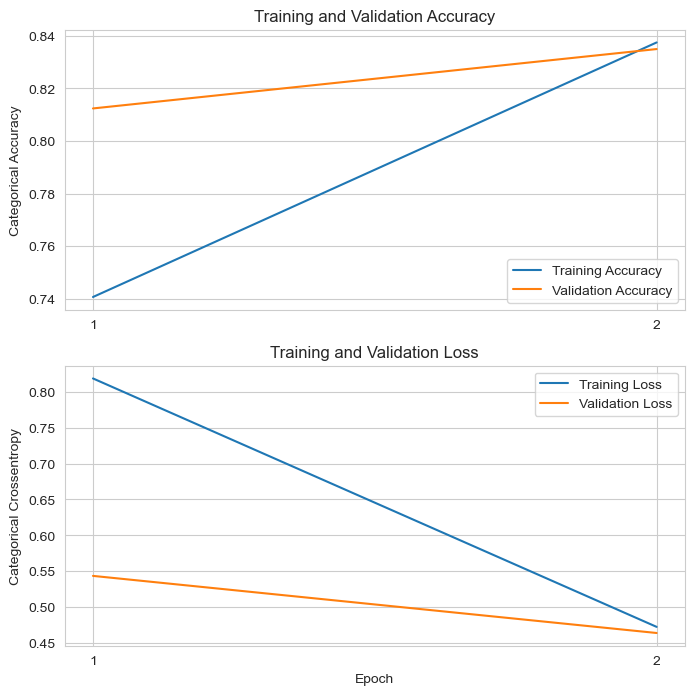

In [18]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Categorical Accuracy')
plt.title('Training and Validation Accuracy')
plt.xticks(range(len(acc)), range(1, len(acc)+1))

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(loss)), range(1, len(loss)+1))

plt.show()

## Test network with new image

In [21]:
labels_dict = dict()
for i, j in zip(range(1, 11), ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']):
    labels_dict[i] = j

def predict_new_images(image_path, model, labels_dict):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image_preprocessed = tf.expand_dims(image, axis=0)
    image_preprocessed = tf.cast(tf.image.resize(image_preprocessed, [224, 224]), tf.uint8)
    
    image_prediction = model.predict(image_preprocessed, verbose=False)
    image_prediction = labels_dict[tf.argmax(image_prediction, axis=-1).numpy()[0] + 1]

    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.title("Prediction: "+ image_prediction)
    plt.show()

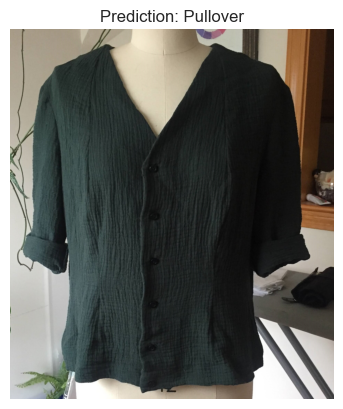

In [22]:
predict_new_images("../data/shirtexample.jpg", model, labels_dict)

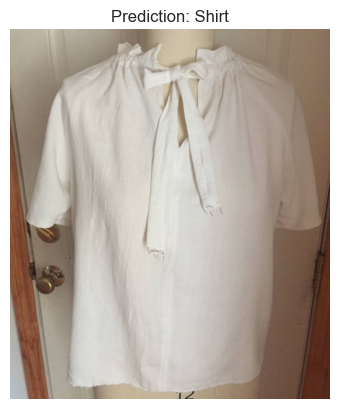

In [23]:
predict_new_images("../data/shirtexamplebow.jpg", model, labels_dict)

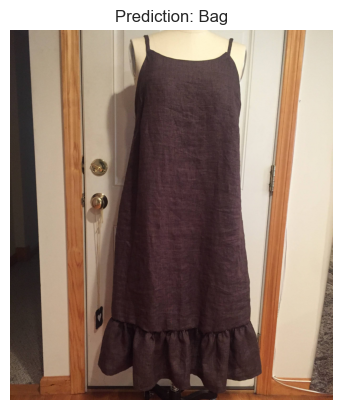

In [24]:
predict_new_images("../data/dressexample.jpg", model, labels_dict)